In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-02-23 20:01:44.708034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 20:01:44.861992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 20:01:44.862010: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-23 20:01:45.764432: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
from data.reaction_diffusion import reaction_diffusion_discrete_solution
from modules.models import ReactionDiffusionPinn, create_dense_model
from modules.data import simulate_reaction_diffusion
from modules.plots import plot_training_loss_linlog
from modules.utils import PrintLossCallback

In [3]:
nt = 100
nx = 256
n_samples = 150
n_init = 150
n_bcs = 150
u0 = 'gauss'
rho = 15.0
nu = 13.0

In [4]:
(tx_samples, u_samples, y_residuals), (tx_init, u_init), (tx_bnd, u_bnd), (X, T, U) = simulate_reaction_diffusion(
    n_samples, n_init, n_bcs, reaction_diffusion_discrete_solution, u0, nu, rho)

2023-02-23 20:01:49.049580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 20:01:49.049973: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 20:01:49.050045: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-23 20:01:49.050110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-23 20:01:49.050212: W tensorflow/c

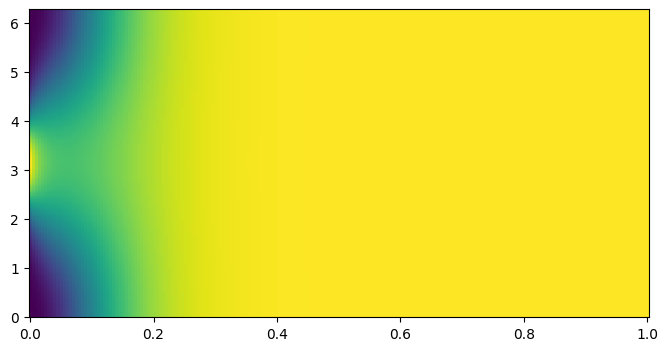

In [5]:
# plot color map of solution
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, U)


In [6]:
backbone = create_dense_model([512, 512], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)
reaction_f = ReactionDiffusionPinn.get_fishers_reaction_function(rho)
model = ReactionDiffusionPinn(backbone, nu, reaction_f) 
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
model.compile(optimizer=optimizer)

In [7]:
y_residual = tf.zeros_like(u_samples)
inputs = (tx_samples, tx_init, tx_bnd)
targets = (u_samples, y_residual, u_init, u_bnd)
cb = [PrintLossCallback(4000-1)]
history = model.fit(inputs, targets, epochs=10, batch_size=128, verbose=0, callbacks=cb)


Epoch: 000000, Lr: 5566.28125, Li: 3.10215, Lb: 4.96130, MAE: 0.93342


1600/1600 [==============================] - 4s 2ms/step


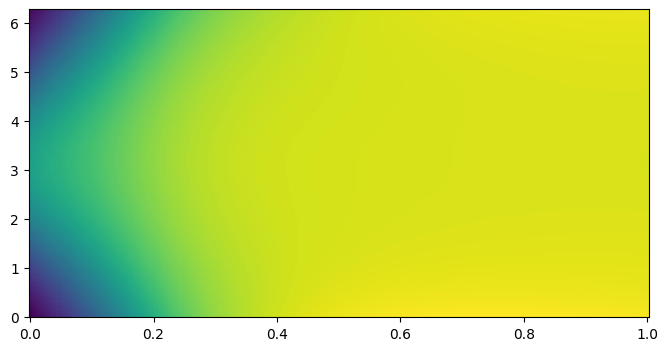

In [15]:
# plot prediction
u_pred = backbone.predict(tf.concat([tf.reshape(T, (-1, 1)), tf.reshape(X, (-1, 1))], axis=1))
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, tf.reshape(u_pred, T.shape))

In [14]:
u_pred.shape

(51200, 1)